In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
from scipy.integrate import quad, fixed_quad
import matplotlib.pyplot as plt
import pickle
import numpy as np
import functools
import sys
from tqdm import tqdm, trange
from aemulusnu_massfunction.utils import *
from aemulusnu_massfunction.emulator import *

from classy import Class

import math
import torch
import gpytorch
from matplotlib import pyplot as plt

import pyccl as ccl


In [3]:
leave_out_box = 'Box0_1400'
print('Leaving out', leave_out_box)

cosmos_f = open('../data/cosmo_params.pkl', 'rb')
cosmo_params = pickle.load(cosmos_f) #cosmo_params is a dict
cosmos_f.close()

a_list_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/alist.pkl'
a_list_f = open(a_list_fname, 'rb')
a_list = pickle.load(a_list_f)
a_list_f.close()

Leaving out Box0_1400


In [4]:
weird_boxes = ['Box63_1400', 'Box35_1400', 'Box_n50_38_1400', 'Box5_1400']


errors = {a:{} for a in a_list}
X = []
Y = []
Xlo = []
Ylo = []
z_to_a = {}
a_to_z = {}
kt = np.logspace(-3, 1, 100) # h/Mpc
for box in tqdm(cosmo_params):
    if(box in weird_boxes):
        continue
    curr_cosmo = cosmo_params[box]
    if(box == 'Box_n50_0_1400'):
        print(curr_cosmo)

    curr_cosmo_values = [curr_cosmo[curr_key] for curr_key in key_ordering]

    h = curr_cosmo['H0']/100

    Ωb =  curr_cosmo['ombh2'] / h**2
    Ωc =  curr_cosmo['omch2'] / h**2

    cosmo = ccl.Cosmology(Omega_c=Ωc,
                          Omega_b=Ωb,
                          h=h,
                          A_s=curr_cosmo['10^9 As']*10**(-9),
                          n_s=curr_cosmo['ns'],
                          w0=curr_cosmo['w0'],
                          m_nu=[curr_cosmo['nu_mass_ev']/3, curr_cosmo['nu_mass_ev']/3, curr_cosmo['nu_mass_ev']/3])


    for a in a_list:
        z = scaleToRedshift(a)
        z_to_a[z] = a
        a_to_z[a] = z

        if(leave_out_box == box):
            Xlo += [curr_cosmo_values + [a]]
        else:
            X+= [curr_cosmo_values + [a]]
        with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_%.2f_params.pkl"%(box, a), "rb") as f:
            MLE_params = pickle.load(f)
            param_values = list(MLE_params.values())
            if(leave_out_box == box):
                Ylo += [param_values]
            else:
                Y+= [param_values]

100%|██████████| 150/150 [00:00<00:00, 1024.04it/s]

{'ns': 0.97000003, 'H0': 67.0, 'w0': -1.0, 'ombh2': 0.0223, 'omch2': 0.12, 'nu_mass_ev': 0.07071068, '10^9 As': 2.10100315}


In [5]:
X = np.array(X)
Y = np.array(Y)
Xlo = np.array(Xlo)
Ylo = np.array(Ylo)
# print(Xlo)
# print(Ylo)

print(X.shape)
print(Y.shape)
################################
print('scaling input')
in_scaler = Normalizer()
in_scaler.fit(X)
X = in_scaler.transform(X)
Xlo = in_scaler.transform(Xlo)
print(X.shape)


print('scaling output')
out_scaler = Standardizer()
out_scaler.fit(Y)
Y = out_scaler.transform(Y)
print(Y.shape)

##REMEMBER TO UNSCALE OUTPUT AND SAVE SCALERS#####

X_train = torch.from_numpy(X).float()
Y_train = torch.from_numpy(Y).float()
n_tasks = len(Y_train[0])

[[ 1.47405133e+00  1.00945830e+00  5.97295990e+01 -1.35573566e+00
   1.74071000e-02  1.33119850e-01  3.65472100e-02  1.00000000e+00]
 [ 1.47405133e+00  1.00945830e+00  5.97295990e+01 -1.35573566e+00
   1.74071000e-02  1.33119850e-01  3.65472100e-02  9.53321000e-01]
 [ 1.47405133e+00  1.00945830e+00  5.97295990e+01 -1.35573566e+00
   1.74071000e-02  1.33119850e-01  3.65472100e-02  8.66399000e-01]
 [ 1.47405133e+00  1.00945830e+00  5.97295990e+01 -1.35573566e+00
   1.74071000e-02  1.33119850e-01  3.65472100e-02  7.87402000e-01]
 [ 1.47405133e+00  1.00945830e+00  5.97295990e+01 -1.35573566e+00
   1.74071000e-02  1.33119850e-01  3.65472100e-02  7.15608000e-01]
 [ 1.47405133e+00  1.00945830e+00  5.97295990e+01 -1.35573566e+00
   1.74071000e-02  1.33119850e-01  3.65472100e-02  6.50360000e-01]
 [ 1.47405133e+00  1.00945830e+00  5.97295990e+01 -1.35573566e+00
   1.74071000e-02  1.33119850e-01  3.65472100e-02  6.20002000e-01]
 [ 1.47405133e+00  1.00945830e+00  5.97295990e+01 -1.35573566e+00
   

In [6]:
from aemulusnu_massfunction.emulator import *


likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=n_tasks)
model = MultitaskGPModel(X_train, Y_train, likelihood)


# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

model.train()
likelihood.train()


training_iterations = 200

1


In [7]:
epochs_iter = tqdm(range(training_iterations), desc="Iteration")


# Create the optimizer with the initial learning rate
optimizer = torch.optim.AdamW(model.parameters(), lr=0.5, amsgrad=True)  # Includes GaussianLikelihood parameters

for i in epochs_iter:
    # Training step
    model.train()
    likelihood.train()

    optimizer.zero_grad()
    output = model(X_train)
    loss = -mll(output, Y_train)
    epochs_iter.set_postfix(loss=loss.item())
    loss.backward()
    optimizer.step()
#     print('Iter %d/%d - Loss: %.4f' % (i + 1, training_iterations, loss.item()))

    # Change learning rate after half of iterations
    if i == training_iterations//10:
        lr = 0.1
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

    if i == training_iterations//2:
        lr = 0.01
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
#-.926

Iteration: 100%|██████████| 200/200 [05:34<00:00,  1.67s/it, loss=-.822] 


In [8]:
from aemulusnu_massfunction.massfunction import *

with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/GP_lo%s.pkl"%(leave_out_box), "wb") as f:
    pickle.dump([model,
                in_scaler,
                out_scaler,
                likelihood,], f)

In [9]:
Emulator = AemulusNu_HMF_Emulator(emulator_loc = "/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/GP_lo%s.pkl"%(leave_out_box))

In [10]:
box =leave_out_box
from aemulusnu_massfunction.massfunction import *

NvM_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_NvsM.pkl'
NvM_f = open(NvM_fname, 'rb')
NvMs = pickle.load(NvM_f) #NvMs is a dictionary of dictionaries
NvM_f.close()

N_data = {}
M_data = {}
aux_data = {}
from scipy.interpolate import interp1d, UnivariateSpline, InterpolatedUnivariateSpline

vol = -1 #Mpc^3/h^3
Mpart = -1

for a in tqdm(a_list):
#     if(a != 1): #TEST
#         continue
    c_data = NvMs[a]

    Ms = c_data['M'] #units of h^-1 Msolar
    N = c_data['N']
    edge_pairs = c_data['edge_pairs']
    assert(len(Ms) == len(edge_pairs))
    assert(len(Ms) == len(N))

    if(vol==-1):
        vol = c_data['vol']
    assert(vol == c_data['vol'])

    if(Mpart==-1):
        Mpart = c_data['Mpart']
    assert(Mpart == c_data['Mpart'])

    N_data[a] = []
    M_data[a] = []
    aux_data[a] = []
    for N_curr, M_curr, edge_pair in zip(N, Ms, edge_pairs):
        N_data[a] += [N_curr]
        M_data[a] += [M_curr]
        aux_data[a] += [{'a':a, 'edge_pair':edge_pair}]

100%|██████████| 14/14 [00:00<00:00, 38006.64it/s]


In [11]:
M_numerics = np.logspace(np.log10(100*Mpart), 16, 50)

jackknife_covs_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_jackknife_covs.pkl'
jackknife_covs_f = open(jackknife_covs_fname, 'rb')
jackknife = pickle.load(jackknife_covs_f)
jackknife_covs_f.close()

jack_covs = {a:jackknife[a][1] for a in N_data}

# Compute the weighted covariance matrix incorporating jackknife and poisson
weighted_cov = {a: jack_covs[a] for a in jack_covs}

param_names = ['d','e','f','g']


true_params = {}
for c_X, c_Y, a in zip(Xlo, Ylo, a_list):
    true_params[a] = c_Y

ccl_cosmo = get_ccl_cosmology(tuple(get_cosmo_vals(cosmo_params[leave_out_box])))

h = cosmo_params[leave_out_box]['H0']/100


100%|██████████| 14/14 [00:30<00:00,  2.18s/it]


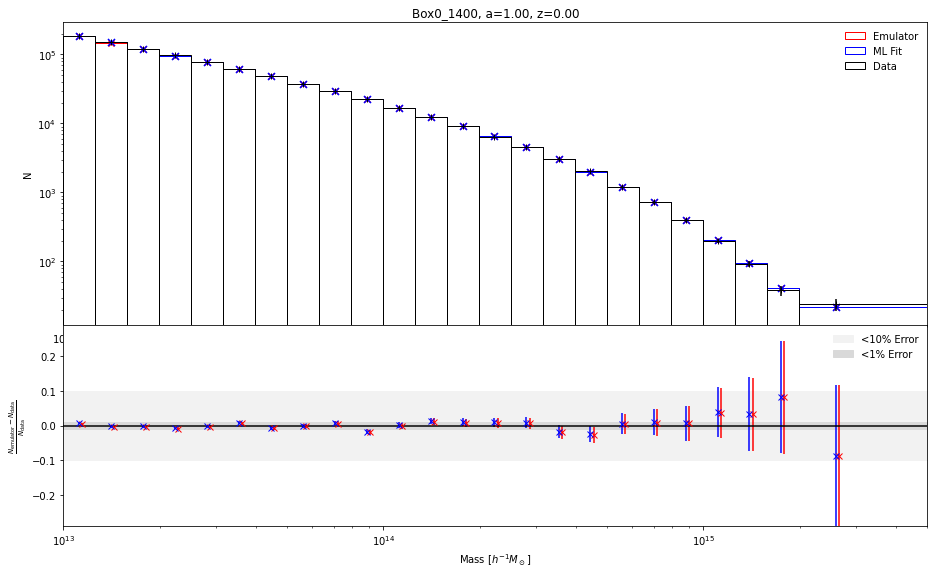

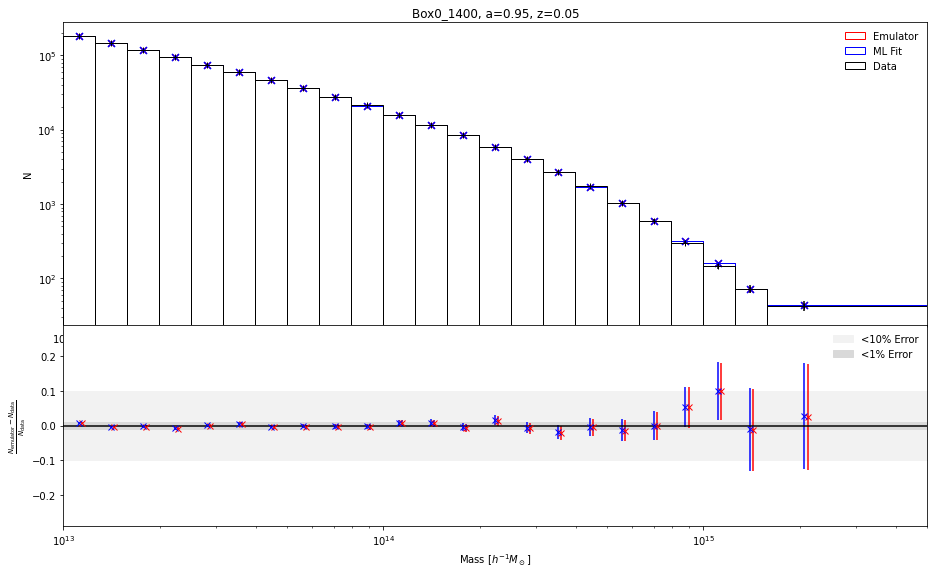

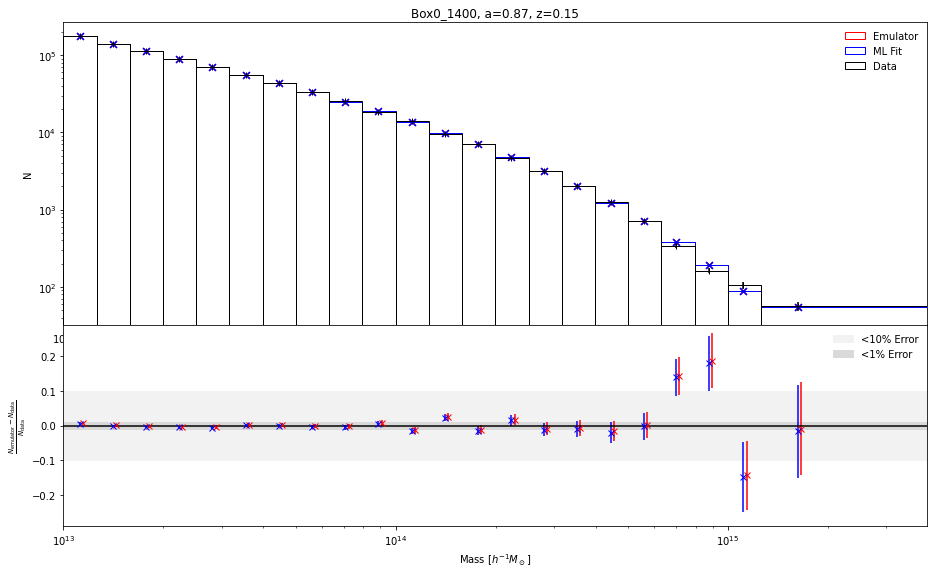

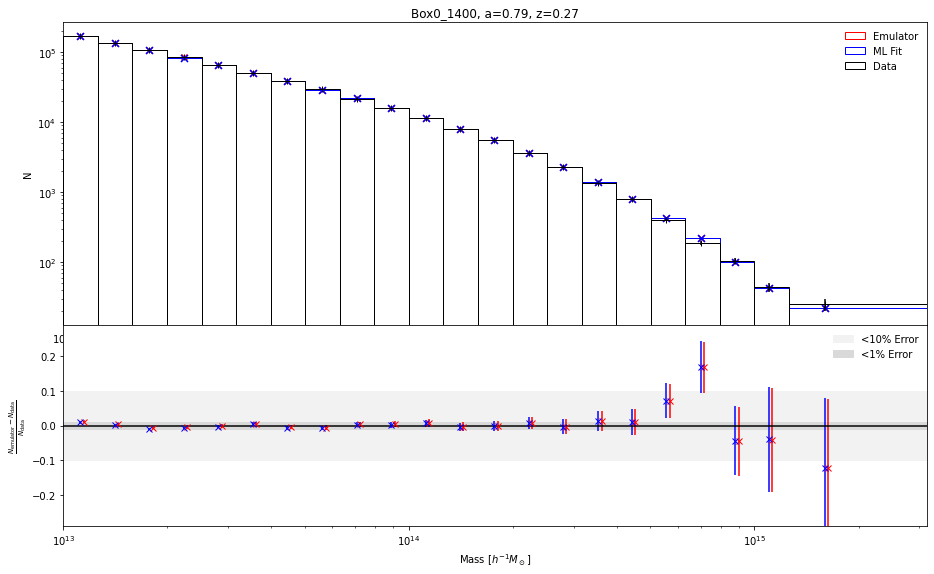

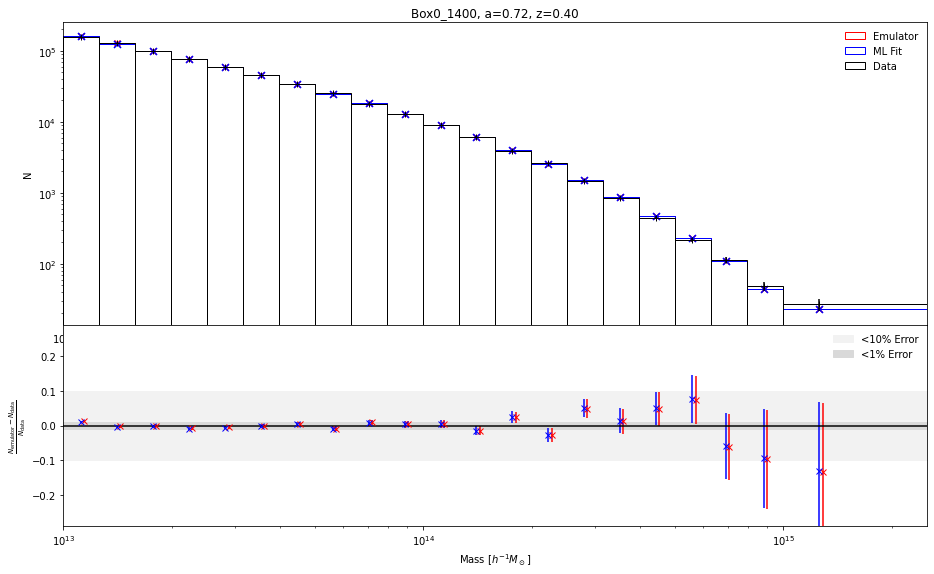

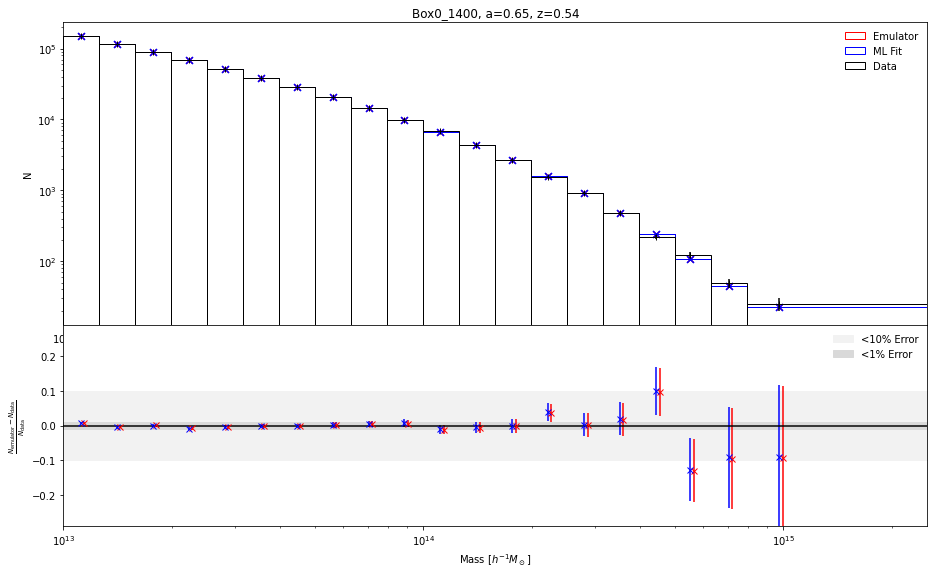

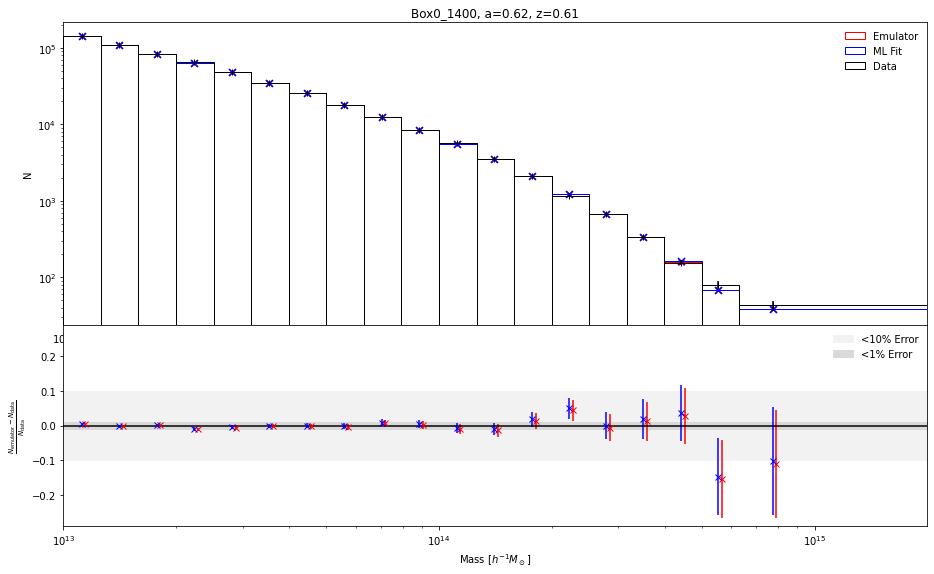

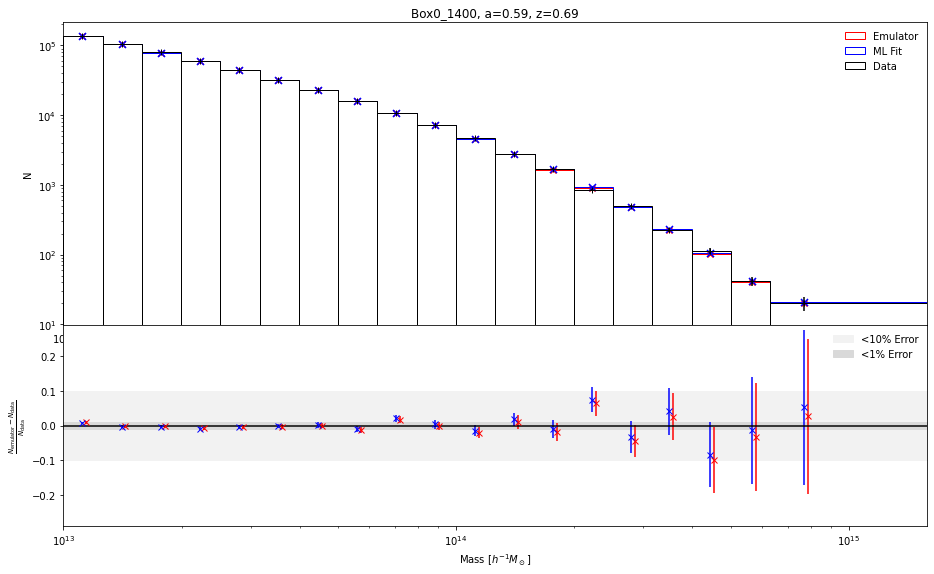

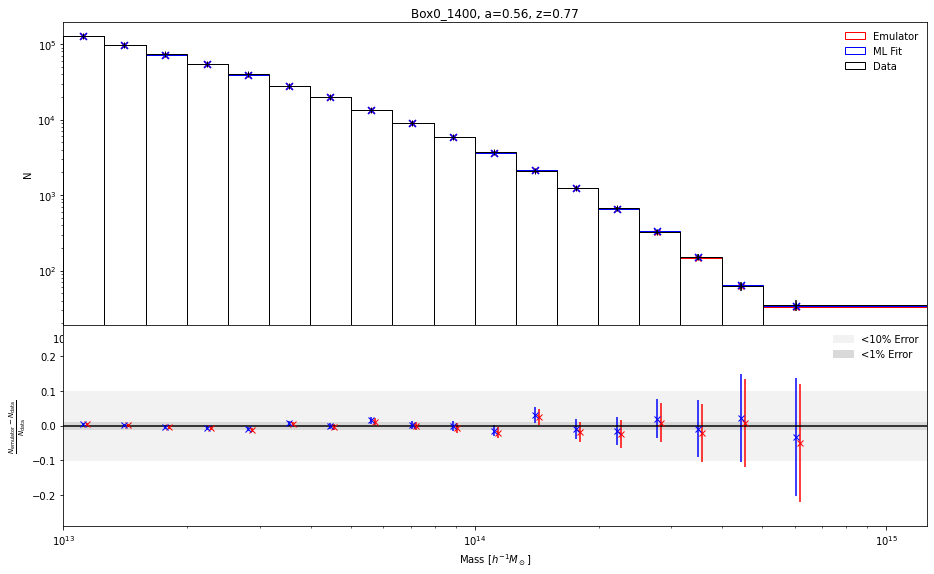

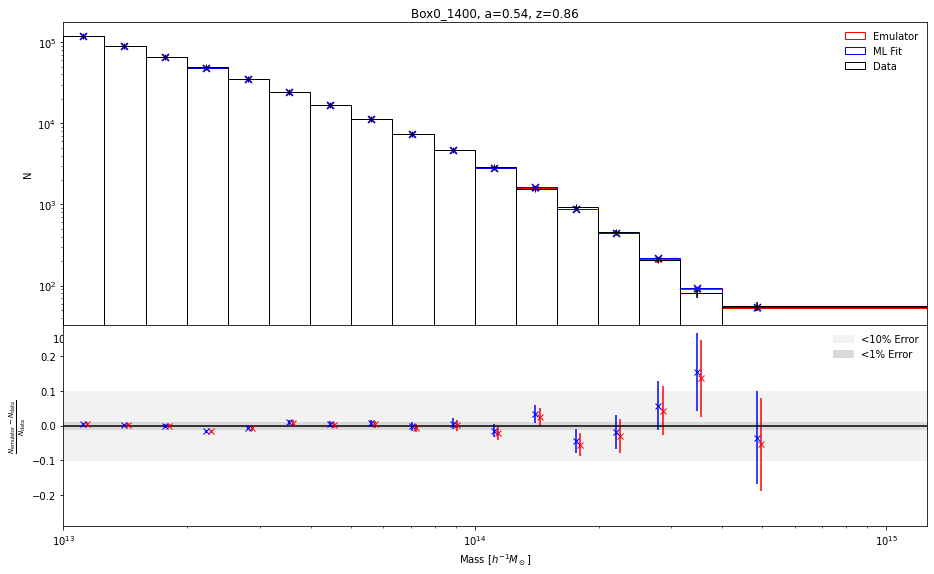

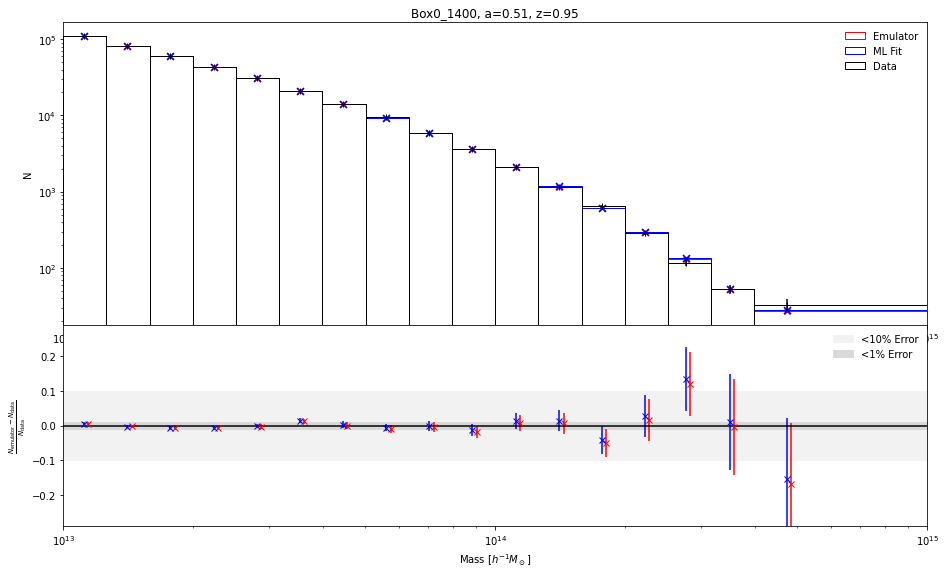

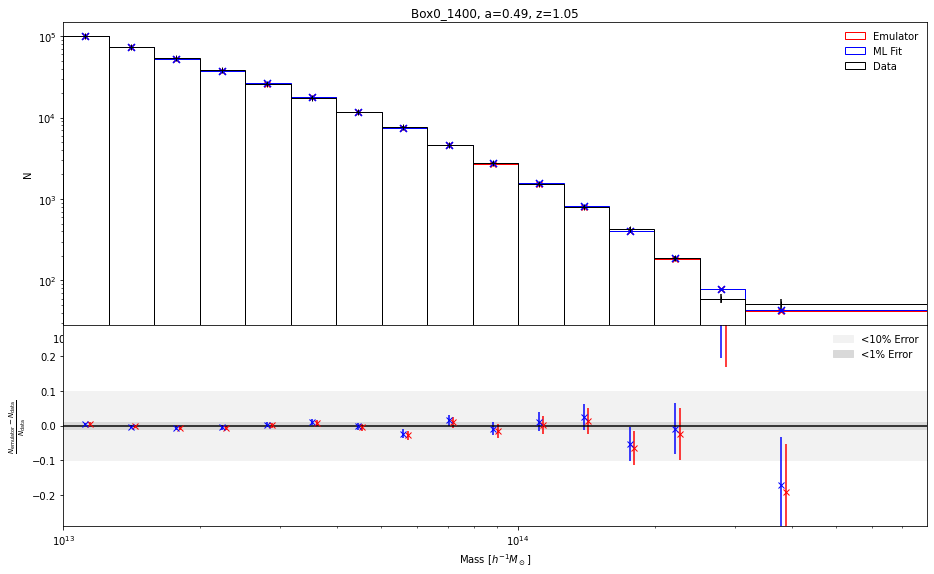

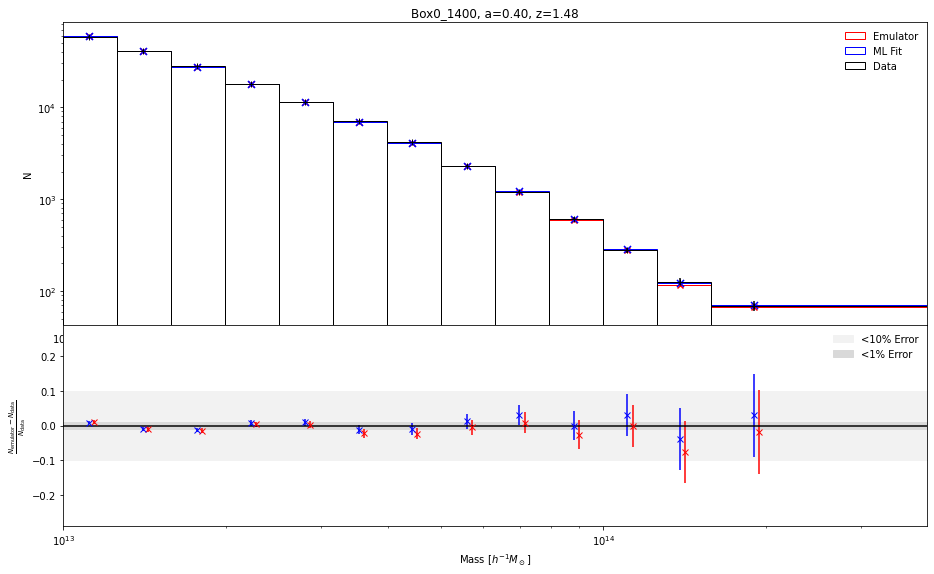

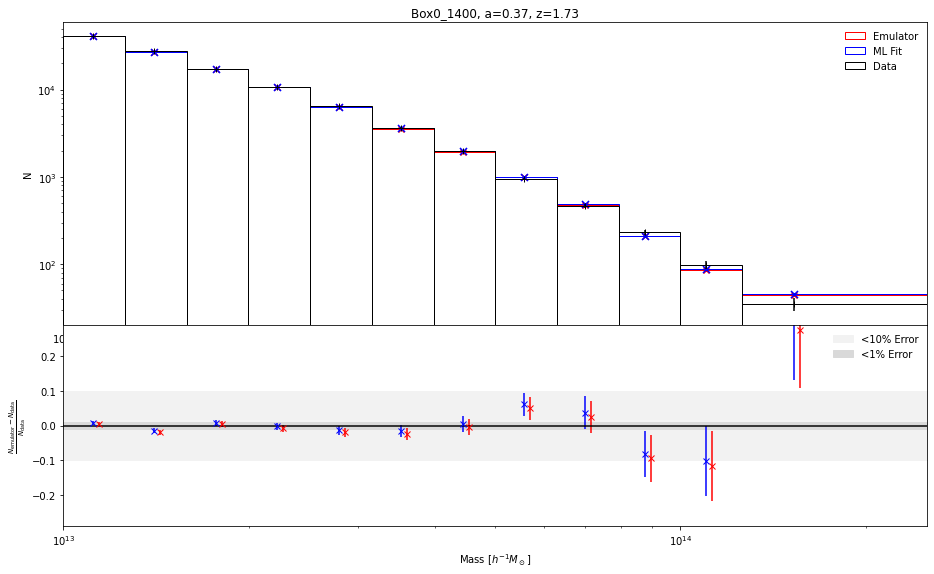

In [12]:
for a in tqdm(a_list):
    yerr = np.sqrt(np.diagonal(weighted_cov[a]))
    fig1 = plt.figure(figsize =(12, 7))

    axs=[fig1.add_axes((0.0,0.4,1,.6)), fig1.add_axes((0.0,0.0,1,.4))]
    plt.subplots_adjust(wspace=0, hspace=0)
    c_data = NvMs[a]

    Ms = M_data[a]
    N = N_data[a]
    edge_pairs = c_data['edge_pairs']

    edges = [edge[0] for edge in edge_pairs]
    edges += [edge_pairs[-1][1]]

    #shade in 1% and 10% error region
    edges = np.array(edges)
    
    

    y1 = 0.1*np.ones_like(N)
    y1 = np.append(y1, y1[-1])
    y1 = np.append(y1[0], y1)

    y2 = -0.1*np.ones_like(N)
    y2 = np.append(y2, y2[-1])
    y2 = np.append(y2[0], y2)

    c_Ms = np.append(Ms, edges[-1])
    c_Ms = np.append(edges[0], c_Ms)
    axs[1].fill_between(c_Ms, y1, y2, alpha=1, color='0.95',label='<10% Error')

    y1 = 0.01*np.ones_like(N)
    y1 = np.append(y1, y1[-1])
    y1 = np.append(y1[0], y1)

    y2 = -0.01*np.ones_like(N)
    y2 = np.append(y2, y2[-1])
    y2 = np.append(y2[0], y2)

    axs[1].fill_between(c_Ms, y1, y2, alpha=1, color='0.85',label='<1% Error')


    dM = np.array([edges[1]-edges[0] for edges in edge_pairs])


    #Emulator 
    tinker_eval_MCMC = Emulator(ccl_cosmo, M_numerics/h, a)*vol/(h**3 * M_numerics * np.log(10)) # h / Msun
    f_dNdM_MCMC =  interp1d(M_numerics, tinker_eval_MCMC, kind='linear',
                            bounds_error=False, fill_value=0.)
    tinker_eval_MCMC = np.array([quad(f_dNdM_MCMC, edge[0],  edge[1], epsabs=0, epsrel=1e-5)[0] for edge in edge_pairs])

    axs[0].scatter(Ms, tinker_eval_MCMC, marker='x', c='red')
    axs[0].bar(x=edges[:-1], height=tinker_eval_MCMC, width=np.diff(edges),
               align='edge', fill=False, ec='red', label='Emulator')
    with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_%.2f_NvMemulator_loo_output.pkl"%(box, a), "wb") as f:
        pickle.dump({'Ms':Ms, 'tinker_eval':tinker_eval_MCMC, 'N':N, 'edges':edges}, f)

    tmp = np.array([c_tmp*10**(0.01)-c_tmp for c_tmp in Ms])
    axs[1].errorbar(Ms + tmp, (tinker_eval_MCMC-N)/N, yerr/N, fmt='x', color='red')

    #ML Fit

    mass_function = MassFuncAemulusNu_fitting()
    mass_function.set_params(true_params[a])
    tinker_eval_MCMC = mass_function(ccl_cosmo, M_numerics/h, a)*vol/(h**3 * M_numerics * np.log(10)) # h / Msun
    f_dNdM_MCMC =  interp1d(M_numerics, tinker_eval_MCMC, kind='linear', 
                            bounds_error=False, fill_value=0.)
    tinker_eval_MCMC = np.array([quad(f_dNdM_MCMC, edge[0],  edge[1], epsabs=0, epsrel=1e-5)[0] for edge in edge_pairs])
    axs[0].scatter(Ms, tinker_eval_MCMC, s=50 , marker='x', c='blue')
    axs[0].bar(x=edges[:-1], height=tinker_eval_MCMC, width=np.diff(edges), 
               align='edge', fill=False, ec='blue', label='ML Fit')
    axs[1].errorbar(Ms, (tinker_eval_MCMC-N)/N, yerr/N, fmt='x', color='blue')



    #Data
    axs[0].bar(x=edges[:-1], height=N, width=np.diff(edges),
           align='edge', fill=False, ec='black', label='Data')
    axs[0].errorbar(Ms, N, yerr, fmt='+', c='black')

    axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    axs[0].legend(frameon=False)
    axs[0].set_ylabel('N')

    axs[1].set_xscale('log')
    # axs[1].set_yscale('lin', linthresh=1e-2)    
    axs[1].legend(frameon=False)
    axs[1].axhline(0, c='black')
    axs[1].set_ylabel('N')
    axs[1].set_xlabel(r'Mass $[h^{-1}M_\odot]$')
    axs[1].set_ylabel(r'$\frac{N_{\rm emulator}-N_{\rm data}}{N_{\rm data}} $')
    axs[0].set_title('%s, a=%.2f, z=%.2f'%(box, a, scaleToRedshift(a)))

    left = np.ceil(np.log10(200*Mpart) * 10) / 10
    axs[0].set_xlim((10**left, np.max(edges)))
    axs[1].set_xlim((10**left, np.max(edges)))
    axs[1].set_ylim((-.29, .29))
    axs[1].set_yticks([-.2, -.1, 0, .1, .2])

    plt.savefig('/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/figures/emulator/%s_emufit_%.2f.pdf'%(box, a), bbox_inches='tight')

(1.0, 1.5)

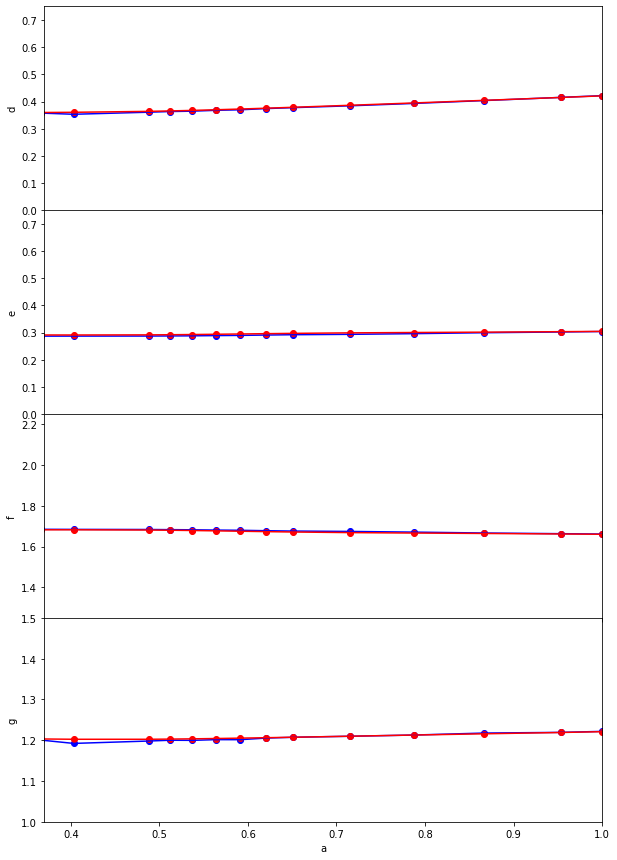

In [14]:

import matplotlib.pyplot as plt
box = 'Box_n50_14_1400'
box = 'Box_n50_0_1400' 
# box = 'Box_n50_42_1400' #eh
box = leave_out_box
# box = 'Box_n50_33_1400'
# box = 'Box_n50_11_1400'
# box = 'Box0_1400'

curr_cosmo_vals = tuple(get_cosmo_vals(cosmo_params[box]))
curr_ccl_cosmo = get_ccl_cosmology(curr_cosmo_vals)

param_names = ['d','e','f','g']
ndim = len(param_names)
fig, axs = plt.subplots(ncols=1, nrows=4, figsize=(10,15), sharex=True)
plt.subplots_adjust(wspace=0, hspace=0)

params = {'d':[], 'e':[], 'f':[], 'g':[]}
paramsEMU = {'d':[], 'e':[], 'f':[], 'g':[]}

for a in a_list:
    R = 8 / (cosmo_params[box]['H0'] / 100)
    sigma8z = cosmo.sigmaR(R, a=a)
    EMU  = (Emulator.predict_params(cosmo_params[box], scaleToRedshift(a))) #, sigma8z))
    
    with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_%.2f_params.pkl"%(box, a), "rb") as f:
        MLE_params = pickle.load(f)
    for key in MLE_params:
        params[key] += [MLE_params[key]]
        paramsEMU[key] += [EMU[key]]


for i, param in enumerate(params):
    axs[i].scatter(a_list, params[param], color='blue')
    axs[i].plot(a_list, params[param], alpha=1, color='blue')

    axs[i].scatter(a_list, paramsEMU[param], color='red')
    axs[i].plot(a_list, paramsEMU[param], alpha=1, color='red')

    axs[i].set_ylabel(param)
    axs[i].set_ylim([0,2])
    axs[i].set_xlim([0.37, 1])

axs[-1].set_xlabel('a')
axs[0].set_ylim([0,.75])
axs[1].set_ylim([0,.75])
axs[2].set_ylim([1.25,2.25])
axs[3].set_ylim([1, 1.5])